# Ground state solvers

## Introduction

<img src="aux_files/H2_gs.png" width="200">

In this tutorial we are going to discuss the ground state calculation interface of Qiskit Nature. The goal is to compute the ground state of a molecular Hamiltonian. This Hamiltonian can be electronic or vibrational. To know more about the preparation of the Hamiltonian, check out the Electronic structure and Vibrational structure tutorials. 

The first step is to define the molecular system. In the following we ask for the electronic part of a hydrogen molecule.

In [2]:
from qiskit import Aer
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.735]]],
                     charge=0, multiplicity=1)
driver = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM, basis='sto3g')

es_problem = ElectronicStructureProblem(driver)
qubit_converter = QubitConverter(JordanWignerMapper())

## The Solver

Then we need to define a solver. The solver is the algorithm through which the ground state is computed. 

Let's first start with a purely classical example: the NumPy minimum eigensolver. This algorithm exactly diagonalizes the Hamiltonian. Although it scales badly, it can be used on small systems to check the results of the quantum algorithms. 

In [22]:
from qiskit.algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

To find the ground state we coul also use the Variational Quantum Eigensolver (VQE) algorithm. The VQE algorithms works by exchanging information between a classical and a quantum computer as depicted in the following figure.

<img src="aux_files/vqe.png" width="600">

Let's initialize a VQE solver.

In [3]:
from qiskit.providers.aer import StatevectorSimulator
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import VQEUCCFactory

quantum_instance = QuantumInstance(backend = Aer.get_backend('aer_simulator_statevector'))
vqe_solver = VQEUCCFactory(quantum_instance)

To define the VQE solver one needs two essential elements:

1. A variational form: here we use the Unitary Coupled Cluster (UCC) ansatz (see for instance [Physical Review A 98.2 (2018): 022322]). Since it is a chemistry standard, a factory is already available allowing a fast initialization of a VQE with UCC. The default is to use all single and double excitations. However, the excitation type (S, D, SD) as well as other parameters can be selected.
2. An initial state: the initial state of the qubits. In the factory used above, the qubits are initialized in the Hartree-Fock (see the electronic structure tutorial) initial state (the qubits corresponding to occupied MOs are $|1\rangle$ and those corresponding to virtual MOs are $|0\rangle$.
3. The backend: this is the quantum machine on which the right part of the figure above will be performed. Here we ask for the perfect quantum emulator (```aer_simulator_statevector```). 

One could also use any available ansatz / initial state or even define one's own. For instance,

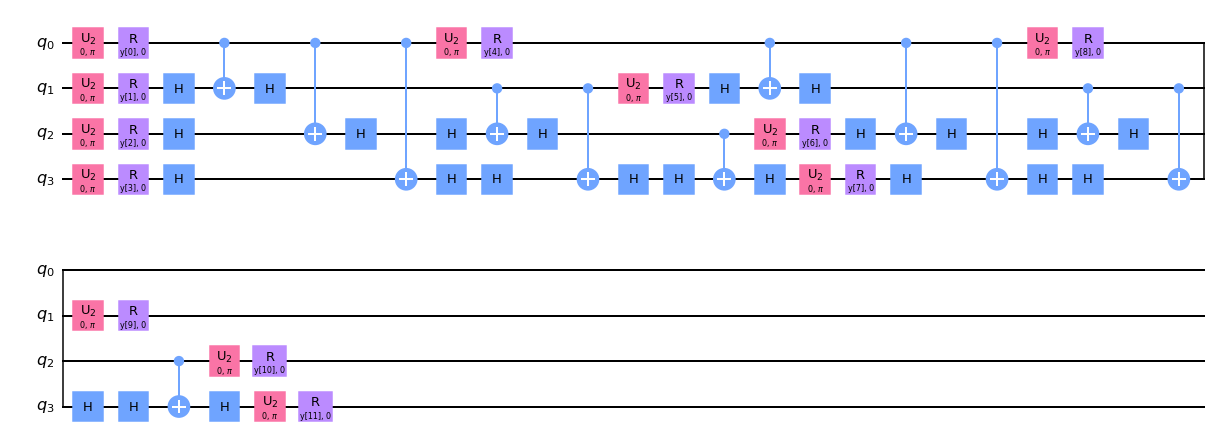

In [7]:
from qiskit.algorithms import VQE
from qiskit.circuit.library import TwoLocal

tl_circuit = TwoLocal(num_qubits=4, rotation_blocks = ['h', 'rx'], entanglement_blocks = 'cz', 
                      entanglement='full', reps=2, parameter_prefix = 'y')
tl_circuit.decompose().draw(output='mpl');

another_solver = VQE(ansatz = tl_circuit, 
                     quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator_statevector')))

## The calculation and results

We are now ready to run the calculation.

In [5]:
from qiskit_nature.algorithms import GroundStateEigensolver

calc = GroundStateEigensolver(qubit_converter, vqe_solver)
res = calc.solve(es_problem)

print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030145
  - computed part:      -1.857275030145
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035696
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: -0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.38894866]
    - computed part:      [0.0  0.0  1.38894866]
  > Dipole moment (a.u.): [0.0  0.0  0.00000004]  Total: 0.00000004
                 (debye): [0.0  0.0  0.0000001]  Total: 0.0000001
 


We can compare the VQE results to the NumPy exact solver and see that they match. 

In [26]:
calc = GroundStateEigensolver(qubit_converter, numpy_solver)
res = calc.solve(es_problem)
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.
                 (debye): [0.0  0.0  0.0]  Total: 0.
 


## Using a filter function

Sometimes the true ground state of the Hamiltonian is not of interest because it lies in a different symmetry sector of the Hilbert space. In this case the NumPy eigensolver can take a filter function to return only the eigenstates with for example the correct number of particles. This is of particular importance in the case of vibrational structure calculations where the true ground state of the Hamiltonian is the vacuum state. A default filter function to check the number of particles is implemented in the different transformations and can be used as

In [6]:
from qiskit_nature.drivers.second_quantization import GaussianForcesDriver
from qiskit_nature.algorithms import NumPyMinimumEigensolverFactory
from qiskit_nature.problems.second_quantization import VibrationalStructureProblem
from qiskit_nature.mappers.second_quantization import DirectMapper

driver = GaussianForcesDriver(logfile='aux_files/CO2_freq_B3LYP_ccpVDZ.log')

vib_problem = VibrationalStructureProblem(driver, num_modals=2, truncation_order=2)

qubit_covnerter = QubitConverter(DirectMapper())

solver_without_filter = NumPyMinimumEigensolverFactory(use_default_filter_criterion=False)
solver_with_filter = NumPyMinimumEigensolverFactory(use_default_filter_criterion=True)

gsc_wo = GroundStateEigensolver(qubit_converter, solver_without_filter)
result_wo = gsc_wo.solve(vib_problem)

gsc_w = GroundStateEigensolver(qubit_converter, solver_with_filter)
result_w = gsc_w.solve(vib_problem)

print(result_wo)
print('\n\n')
print(result_w)

=== GROUND STATE ENERGY ===
 
* Vibrational ground state energy (cm^-1): (1.1e-11-0j)
The number of occupied modals is
- Mode 0: [0.0, 0.0, 0.0, 0.0]



=== GROUND STATE ENERGY ===
 
* Vibrational ground state energy (cm^-1): (2553.464851175474+0j)
The number of occupied modals is
- Mode 0: [0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999]


In [17]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright